In [45]:
import glob
import numpy as np
import cv2
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout

from tensorflow.keras import layers, models

from skimage.transform import resize

import matplotlib.pyplot as plt
import csv

import random

import os

import pandas as pd
import tensorflow as tf


## Steuerungs-Parameter

In [2]:
#Parameter

#Speicherort der Test-Daten for example './GTSRB/Training'
TRAINING_DATA_PATH = "Z:/Daten/Universität/DSKI_Projektarbeit/DATA_DSKI_Projekt/GTSRB_Final_Training_Images/GTSRB/Final_Training/Images" #"C:/Users/de136581/Documents/Uni/SoSe_2024/DSKI_Projekt/Data_trafic_Signs/Final_Training/GTSRB/Final_Training/Images" 

TEST_DATA_PATH = "Z:/Daten/Universität/DSKI_Projektarbeit/DATA_DSKI_Projekt/GTSRB_Online-Test-Images/GTSRB/Online-Test/Images"

## Allgemeine Funktionen

In [3]:
# function for reading the images
# arguments: path to the traffic sign data, for example './GTSRB/Training'
# returns: list of images, list of corresponding labels 
def readTrafficSigns(rootpath):
    '''Reads traffic sign data for German Traffic Sign Recognition Benchmark.

    Arguments: path to the traffic sign data, for example './GTSRB/Training'
    Returns:   list of images, list of corresponding labels'''
    images = [] # images
    labels = [] # corresponding labels
    # loop over all 42 classes
    for c in range(0,43):
        prefix = rootpath + '/' + format(c, '05d') + '/' # subdirectory for class
        gtFile = open(prefix + 'GT-'+ format(c, '05d') + '.csv') # annotations file
        gtReader = csv.reader(gtFile, delimiter=';') # csv parser for annotations file
        next(gtReader) # skip header
        # loop over all images in current annotations file
        for row in gtReader:
            images.append(plt.imread(prefix + row[0])) # the 1th column is the filename
            labels.append(row[7]) # the 8th column is the label
        gtFile.close()
    return images, labels

def format_imgs(imgs_lst):
    new_size = (32, 32)
    resized_images = []
    for img in imgs_lst:
        resized_img = resize(img, new_size, anti_aliasing=True)
        resized_images.append(resized_img)

    return np.array(resized_images)

In [13]:
# Mapper Funktion Klassennummer - Verkehrszeichen
def get_traffic_sign_name(class_id):
    # Dictionary that maps class IDs to traffic sign names in German
    class_id_to_name = {
        0: "Geschwindigkeitsbegrenzung (20km/h)",
        1: "Geschwindigkeitsbegrenzung (30km/h)",
        2: "Geschwindigkeitsbegrenzung (50km/h)",
        3: "Geschwindigkeitsbegrenzung (60km/h)",
        4: "Geschwindigkeitsbegrenzung (70km/h)",
        5: "Geschwindigkeitsbegrenzung (80km/h)",
        6: "Ende der Geschwindigkeitsbegrenzung (80km/h)",
        7: "Geschwindigkeitsbegrenzung (100km/h)",
        8: "Geschwindigkeitsbegrenzung (120km/h)",
        9: "Überholverbot",
        10: "Überholverbot für Fahrzeuge über 3,5 Tonnen",
        11: "Vorfahrt an der nächsten Kreuzung",
        12: "Vorfahrtstraße",
        13: "Vorfahrt gewähren",
        14: "Halt",
        15: "Verbot für Fahrzeuge",
        16: "Verbot für Fahrzeuge über 3,5 Tonnen",
        17: "Einfahrt verboten",
        18: "Allgemeine Gefahr",
        19: "Gefährliche Kurve nach links",
        20: "Gefährliche Kurve nach rechts",
        21: "Doppelkurve",
        22: "Unebene Fahrbahn",
        23: "Schleudergefahr bei Nässe oder Schmutz",
        24: "Fahrbahnverengung",
        25: "Baustelle",
        26: "Ampel",
        27: "Fußgänger",
        28: "Kinder",
        29: "Radfahrer",
        30: "Schnee- oder Eisglätte",
        31: "Wildwechsel",
        32: "Ende aller Streckenverbote",
        33: "Rechts abbiegen",
        34: "Links abbiegen",
        35: "Geradeaus",
        36: "Geradeaus oder rechts",
        37: "Geradeaus oder links",
        38: "Rechts vorbei",
        39: "Links vorbei",
        40: "Kreisverkehr",
        41: "Ende des Überholverbots",
        42: "Ende des Überholverbots für Fahrzeuge über 3,5 Tonnen"
    }
    
    # Return the name of the traffic sign corresponding to the given class ID
    return class_id_to_name.get(class_id, "Unbekannte Klassennummer")

### Dateneinlesen

für alle Klassifizierungen

In [36]:
# Trainings und Testdaten vorbereiten
trainImages, trainLabels =  readTrafficSigns(TRAINING_DATA_PATH)

## Binäre Klassifikation

In [40]:
bin_labels = np.where( np.array(trainLabels) == 1, 1, 0)
# Train-Test-Aufteilung
bin_img_train, bin_img_test, bin_labels_train, bin_labels_test = train_test_split(trainImages,  bin_labels, test_size=0.2, random_state=42)

# Daten normalisieren
bin_img_train = format_imgs(bin_img_train) / 255
bin_img_test = format_imgs(bin_img_test) / 255

# Labels zu kategorischen Daten umwandeln
bin_labels_train = to_categorical(bin_labels_train, 2)
bin_labels_test = to_categorical(bin_labels_test, 2)

In [46]:
# CNN-Modell erstellen
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 3)),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(2, activation='softmax')
])

# Modell kompilieren
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Modell trainieren
history = model.fit(bin_img_train, bin_labels_train, epochs=10, validation_data=(bin_img_test, bin_labels_test), batch_size=32)

### Gütemaß Genauigkeit (Accuracy)

**Beachte:** Die Genauigkeit gibt an, wie groß der Anteil aller von einem Klassifikator korrekt bewerteten Objekte an der Gesamtheit aller Objekte ist.

246/246 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 1.0000 - loss: 7.3262e-17
Validation accuracy: 1.0


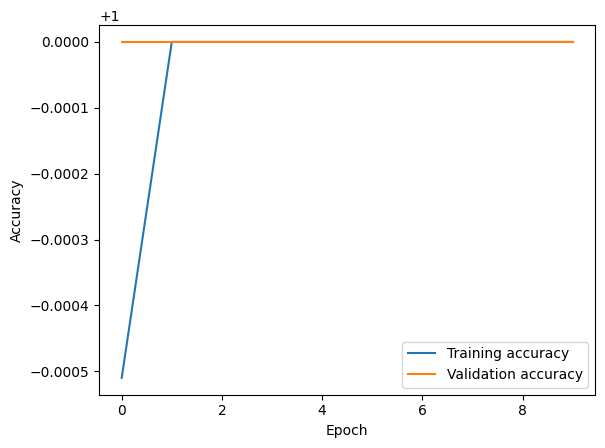

In [49]:
# Modellbewertung
val_loss, val_acc = model.evaluate(bin_img_test, bin_labels_test)
print(f'Validation accuracy: {val_acc}')

# Plotten der Trainingsgeschichte
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'], label='Training accuracy')
plt.plot(history.history['val_accuracy'], label='Validation accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.show()

## CNN Multiclass

In [23]:
# Train-Test-Aufteilung
img_train, img_test, labels_train, labels_test = train_test_split(trainImages,  trainLabels, test_size=0.2, random_state=42)
# One-Hot-Encoding der Labels
labels_train = to_categorical(labels_train, 43)
labels_test = to_categorical(labels_test, 43)

img_train = format_imgs(img_train)
img_test = format_imgs(img_test)

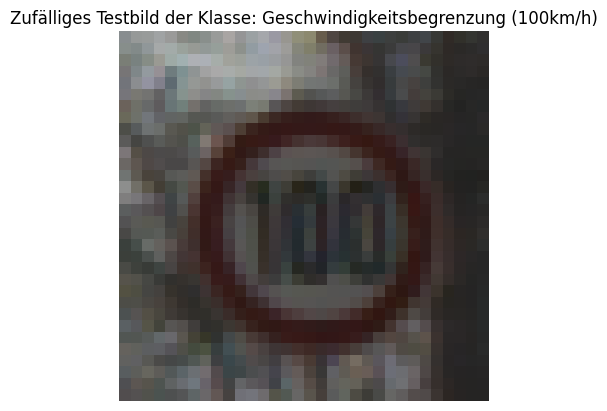

In [20]:
# Wähle ein zufälliges Bild aus dem Trainingsdatensatz
random_index = np.random.randint(0, len(img_train))
bsp_image = img_train[random_index]
bsp_label = labels_train[random_index]

# Zeige das Bild an
plt.imshow(bsp_image.squeeze(), cmap='gray')
plt.title(f"Zufälliges Testbild der Klasse: {get_traffic_sign_name(np.argmax(bsp_label))}")
plt.axis('off')
plt.show()

In [9]:
# Modellarchitektur
# Definiere das Modell
model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Flatten())
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dense(43, activation='softmax'))  # 43 Klassen für Verkehrszeichen

# Kompiliere das Modell
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

c:\Users\felix\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [10]:
model.fit(img_train, labels_train, epochs=10, batch_size=32, validation_data=(img_test, labels_test)) #, validation_data=(img_test, labels_test)

Epoch 1/10
981/981 ━━━━━━━━━━━━━━━━━━━━ 16s 15ms/step - accuracy: 0.4358 - loss: 2.2144 - val_accuracy: 0.8776 - val_loss: 0.5075
Epoch 2/10
981/981 ━━━━━━━━━━━━━━━━━━━━ 14s 14ms/step - accuracy: 0.8992 - loss: 0.4045 - val_accuracy: 0.9143 - val_loss: 0.3131
Epoch 3/10
981/981 ━━━━━━━━━━━━━━━━━━━━ 14s 15ms/step - accuracy: 0.9504 - loss: 0.2142 - val_accuracy: 0.9420 - val_loss: 0.2277
Epoch 4/10
981/981 ━━━━━━━━━━━━━━━━━━━━ 14s 15ms/step - accuracy: 0.9643 - loss: 0.1425 - val_accuracy: 0.9589 - val_loss: 0.1694
Epoch 5/10
981/981 ━━━━━━━━━━━━━━━━━━━━ 14s 14ms/step - accuracy: 0.9743 - loss: 0.1060 - val_accuracy: 0.9686 - val_loss: 0.1427
Epoch 6/10
981/981 ━━━━━━━━━━━━━━━━━━━━ 14s 15ms/step - accuracy: 0.9805 - loss: 0.0816 - val_accuracy: 0.9661 - val_loss: 0.1481
Epoch 7/10
981/981 ━━━━━━━━━━━━━━━━━━━━ 14s 15ms/step - accuracy: 0.9838 - loss: 0.0647 - val_accuracy: 0.9702 - val_loss: 0.1298
Epoch 8/10
981/981 ━━━━━━━━━━━━━━━━━━━━ 14s 15ms/step - accuracy: 0.9857 - loss: 0.0536 - 

In [ ]:
#Testen des Modells:
    
# Wähle ein zufälliges Bild aus dem Testdatensatz
random_index = np.random.randint(0, len(img_test))
test_image = img_test[random_index]
true_label = labels_test[random_index]

# Zeige das Bild an
plt.imshow(test_image.squeeze(), cmap='gray')
plt.title(f"Zufälliges Testbild der Klasse: {get_traffic_sign_name(np.argmax(true_label))}")
plt.axis('off')
plt.show()

# Klassifiziere das Bild mit dem trainierten Modell
predicted_probs = model.predict(np.expand_dims(test_image, axis=0))
predicted_class = np.argmax(predicted_probs)

# Gib die Klassifizierung und die Wahrscheinlichkeit aus
print(f"Vorhergesagte Klasse: {predicted_class}")
print(f"Wahrscheinlichkeit: {predicted_probs[0][predicted_class]:.2f}")

### Modellevaluation

... hier noch verschiedene Gütemaße und Wahrheitsmatrix

In [ ]:
# Modellbewertung
val_loss, val_acc = model.evaluate(bin_img_test, bin_labels_test)
print(f'Validation accuracy: {val_acc}')

# Plotten der Trainingsgeschichte
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'], label='Training accuracy')
plt.plot(history.history['val_accuracy'], label='Validation accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.show()

## SVM als Klassifizierer

In [4]:
import os
import numpy as np
import cv2
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report

In [5]:
# Trainings und Testdaten vorbereiten
trainImages, trainLabels =  readTrafficSigns(TRAINING_DATA_PATH)

In [6]:
images = format_imgs(trainImages)

In [7]:
labels = trainLabels

In [8]:
# Überprüfen, ob alle Bilder die gleiche Größe haben
print("Bildgröße:", np.array(images).shape)  # Sollte (Anzahl_Bilder, 32, 32) sein

# Daten normalisieren und in das richtige Format bringen
X = np.array(images).reshape(len(images), -1) / 255.0
y = np.array(labels)

Bildgröße: (39209, 32, 32, 3)


In [9]:
# Daten in Trainings- und Testdaten aufteilen
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [10]:
# SVM Modell erstellen
svm_model = SVC(kernel='linear', C=1.0, random_state=42)

In [11]:
# Trainingszeit messen
import time
start_time = time.time()

svm_model.fit(X_train, y_train)

end_time = time.time()
training_time = end_time - start_time
print(f"Trainingszeit: {training_time:.2f} Sekunden")

Trainingszeit: 3909.09 Sekunden


In [12]:
# Vorhersagen auf den Testdaten
y_pred = svm_model.predict(X_test)

# Genauigkeit berechnen
accuracy = accuracy_score(y_test, y_pred)
print(f'Genauigkeit: {accuracy * 100:.2f}%')

# Klassifikationsbericht anzeigen
print(classification_report(y_test, y_pred))

Genauigkeit: 13.22%
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        38
           1       0.18      0.33      0.24       496
          10       0.07      0.81      0.14       370
          11       0.00      0.00      0.00       236
          12       0.88      0.03      0.06       450
          13       0.39      0.30      0.34       452
          14       0.00      0.00      0.00       162
          15       0.00      0.00      0.00       120
          16       0.00      0.00      0.00        90
          17       0.00      0.00      0.00       219
          18       0.00      0.00      0.00       231
          19       0.00      0.00      0.00        43
           2       0.12      0.46      0.20       450
          20       0.00      0.00      0.00        78
          21       0.00      0.00      0.00        63
          22       0.00      0.00      0.00        86
          23       0.00      0.00      0.00       109
       

c:\Users\felix\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\felix\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\felix\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

## Vergleich SVM vs CNN

... aufgreifen vorheriger Gütemaße und hier dann folgender Verglich von SVM und CNN